In [165]:
import torch
import torch.nn.functional as F
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None

        # Hook for activations
        self.target_layer = dict(model.named_modules())[target_layer_name]
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        """Save activations from the forward pass."""
        self.activations = output[0] if isinstance(output, tuple) else output

    def save_gradient(self, module, grad_input, grad_output):
        """Save gradients from the backward pass."""
        self.gradients = grad_output[0] if isinstance(grad_output, tuple) else grad_output

    def __call__(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)

        # Handle output directly as a tensor (without checking for logits)
        if isinstance(output, torch.Tensor):
            target = output[0, target_class]  # For batch size = 1, select the target class score
        else:
            raise ValueError(f"Unexpected output type: {type(output)}")

        # Backward pass
        self.model.zero_grad()
        target.backward()

        # Check activations and gradients
        print(f"Activations shape: {self.activations.shape}")
        print(f"Gradients shape: {self.gradients.shape}")

        # Get the number of dimensions of the activations
        ndims = self.activations.ndimension()

        # Average the gradients across the spatial dimensions
        if ndims == 4:  # For CNNs: [batch_size, channels, height, width]
            weights = torch.mean(self.gradients, dim=(2, 3))  # Average over height and width
        elif ndims == 3:  # For ViTs: [batch_size, channels, sequence_length]
            weights = torch.mean(self.gradients, dim=2)  # Average over sequence length
        else:
            raise ValueError(f"Unexpected activations shape: {self.activations.shape}")

        # Expand the weights to match the shape of the activations
        if ndims == 4:
            weights = weights[:, :, None, None]  # Broadcast weights over height and width
        elif ndims == 3:
            weights = weights[:, :, None]  # Broadcast weights over sequence length

        # Grad-CAM calculation: weighted sum of activations
        grad_cam = torch.sum(weights * self.activations, dim=1)  # Sum over channels
        grad_cam = torch.nn.functional.relu(grad_cam)  # Apply ReLU to ensure non-negative values

        # Check the final shape of the grad_cam before returning
        print(f"Grad-CAM shape: {grad_cam.shape}")

        # Convert the tensor to NumPy array for plotting
        return grad_cam[0].detach().cpu().numpy()  # Detach, move to CPU, and convert to NumPy


In [166]:
from collections import OrderedDict
import torch
state_dict = torch.load('/Users/eddie/Trauma_THOMPSON/Trauma_THOMPSON/VideoSwin/exps/uniformerv2_regular/best_acc_top1_epoch_22.pth')['state_dict']
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    print(k)
    if k=="cls_head.fc_cls.weight":
        name = 'transformer.proj.2.weight'
        new_state_dict[name] = v
    elif k=="cls_head.fc_cls.bias":
        name = 'transformer.proj.2.bias'
        new_state_dict[name] = v
    elif k=='backbone.transformer.norm.weight':
        name = 'transformer.proj.0.weight'
        new_state_dict[name] = v
    elif k=='backbone.transformer.norm.bias':
        name = 'transformer.proj.0.bias'
        new_state_dict[name] = v
    else:
        name = k[9:]  # remove `module.`
        new_state_dict[name] = v
import torch
from uniformerv2.uniformerv2 import uniformerv2_b16
model = uniformerv2_b16(
        pretrained=False, 
        num_classes = 162,
        t_size=4, backbone_drop_path_rate=0.2, drop_path_rate=0.4,
        dw_reduction=1.5,
        no_lmhra=True,
        temporal_downsample=False
    )

model.load_state_dict(new_state_dict,strict=True)
# print(model)

C:\Users\eddie\AppData\Local\Temp\ipykernel_27864\1828939717.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/Users/eddie/Trauma_THOMPSON/Trauma

backbone.class_embedding
backbone.positional_embedding
backbone.conv1.weight
backbone.ln_pre.weight
backbone.ln_pre.bias
backbone.transformer.temporal_cls_token
backbone.transformer.balance
backbone.transformer.resblocks.0.attn.in_proj_weight
backbone.transformer.resblocks.0.attn.in_proj_bias
backbone.transformer.resblocks.0.attn.out_proj.weight
backbone.transformer.resblocks.0.attn.out_proj.bias
backbone.transformer.resblocks.0.ln_1.weight
backbone.transformer.resblocks.0.ln_1.bias
backbone.transformer.resblocks.0.mlp.c_fc.weight
backbone.transformer.resblocks.0.mlp.c_fc.bias
backbone.transformer.resblocks.0.mlp.c_proj.weight
backbone.transformer.resblocks.0.mlp.c_proj.bias
backbone.transformer.resblocks.0.ln_2.weight
backbone.transformer.resblocks.0.ln_2.bias
backbone.transformer.resblocks.1.attn.in_proj_weight
backbone.transformer.resblocks.1.attn.in_proj_bias
backbone.transformer.resblocks.1.attn.out_proj.weight
backbone.transformer.resblocks.1.attn.out_proj.bias
backbone.transform

<All keys matched successfully>

In [167]:
# Example model (replace with actual UniformerV2 model)
# model = ...  # Load your UniformerV2 model here
target_layer = 'transformer.dec.3.ln_3'  # For example, last attention layer

# Specify input size (H, W)
input_size = (224, 224)  # Or (height, width) for your video frames


In [168]:
grad_cam = GradCAM(model=model, target_layer_name=target_layer)


In [169]:
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

def load_frames(frame_dir, size=224, max_frames=32):
    frame_files = sorted([os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(('.jpg', '.png'))])
    frames = []
    
    j = 0
    for i, frame_path in enumerate(frame_files[j:max_frames+j]):
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (size, size))
        frames.append(frame)
    
    frames = np.array(frames).transpose((3, 0, 1, 2))  # T, C, H, W #0, 3, 1, 2
    frames = torch.tensor(frames, dtype=torch.float32)/255.0
    # frames = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(frames)
    return frames.unsqueeze(0)  # Add batch dimension


frame_dir = "/Users/eddie/Trauma_THOMPSON/Trauma_THOMPSON/new_dataset/regular/test/P01_04_0" # Directory with extracted frames
input_tensor = load_frames(frame_dir)
print(input_tensor.shape)

torch.Size([1, 3, 32, 224, 224])


In [ ]:

# import torch
# print(torch.__version__, torch.cuda.is_available())

# from multiprocessing import Process

# if __name__ == '__main__':    
#     # Check MMAction2 installaation
#     import mmaction
#     print(mmaction.__version__)

#     import mmcv
#     print(mmcv.__version__)

#     # Check MMCV installation
#     from mmcv.ops import get_compiling_cuda_version, get_compiler_version
#     print(get_compiling_cuda_version())
#     print(get_compiler_version())

#     # Check MMEngine installation
#     from mmengine.utils.dl_utils import collect_env
#     print(collect_env())

#     from mmaction.apis import inference_recognizer, init_recognizer
#     from mmengine import Config

#     from operator import itemgetter

#     import os.path as osp
#     import mmengine
#     from mmengine.runner import Runner

# from mmengine.runner import Runner
# checkpoint = '/Users/eddie/Trauma_THOMPSON/Trauma_THOMPSON/VideoSwin/exps/videomae_anticipation_regular/best_acc_top1_epoch_24.pth'



# cfg = '/Users/eddie/Trauma_THOMPSON/Trauma_THOMPSON/VideoSwin/videomae_anticipation_regular.py'

# cfg = Config.fromfile(cfg)

# cfg.load_from = checkpoint

# cfg.work_dir = './exps/videomae_anticipation_regular'

# cfg.test_dataloader.dataset.ann_file = '/Users/eddie/Trauma_THOMPSON/Trauma_THOMPSON/new_dataset/anticipation_annotations_regular_test.txt'

# cfg.test_dataloader.dataset.data_prefix.img = '/Users/eddie/Trauma_THOMPSON/Trauma_THOMPSON/new_dataset/regular/test/'


# # build the runner from config

# if 'runner_type' not in cfg:

#    # build the default runner

#    runner_test = Runner.from_cfg(cfg)

# else:

#    # build customized runner from the registry

#    # if 'runner_type' is set in the cfg

#    runner_test = Runner.build(cfg)


# # start testing

# runner_test.test()

In [ ]:
 # Example input (C, F, H, W)
target_class = 0  # Class index to visualize

# Generate heatmap
heatmap = grad_cam(input_tensor, target_class)


Activations shape: torch.Size([788, 8, 768])
Gradients shape: torch.Size([788, 8, 768])
Grad-CAM shape: torch.Size([788, 768])


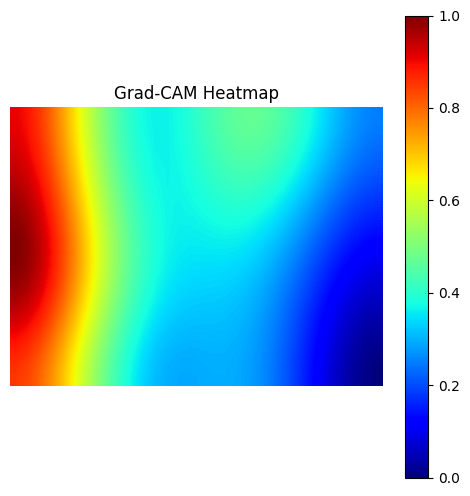

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter

def plot_grad_cam(grad_cam, original_image=None, target_height=None, target_width=None, smooth=True):
    # Normalize the Grad-CAM output to [0, 1] for visualization
    grad_cam = (grad_cam - np.min(grad_cam)) / (np.max(grad_cam) - np.min(grad_cam))  # Normalize to [0, 1]

    # Determine the correct height and width for reshaping based on num_tokens
    num_tokens = grad_cam.shape[0]
    
    # For 768 tokens, we can assume a 24x32 grid (or adjust as needed for other models)
    if num_tokens == 768:
        height, width = 24, 32
    else:
        # If your model uses a different number of tokens, adjust here accordingly
        sqrt_tokens = int(np.sqrt(num_tokens))
        height, width = sqrt_tokens, num_tokens // sqrt_tokens
        if height * width != num_tokens:
            raise ValueError(f"Cannot reshape {num_tokens} tokens into a square grid")

    grad_cam = grad_cam.reshape(height, width)

    # Default grad_cam_resized to the original grad_cam
    grad_cam_resized = grad_cam

    # Upsample the Grad-CAM heatmap to the target size (if original image is provided)
    if original_image is not None:
        # Get target size from the original image (height, width)
        target_height = target_height or original_image.shape[1]  # Use original image height if not provided
        target_width = target_width or original_image.shape[2]  # Use original image width if not provided
        
        # Use bilinear interpolation to resize the Grad-CAM heatmap
        grad_cam_resized = resize(grad_cam, (target_height, target_width), mode='reflect', anti_aliasing=True)

    # Apply Gaussian smoothing if requested
    if smooth:
        grad_cam_resized = gaussian_filter(grad_cam_resized, sigma=8)  # You can adjust sigma for more/less smoothing

    # Normalize again after smoothing to ensure proper scaling
    grad_cam_resized = (grad_cam_resized - np.min(grad_cam_resized)) / (np.max(grad_cam_resized) - np.min(grad_cam_resized))

    # Plot Grad-CAM Heatmap only
    fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis
    ax.imshow(grad_cam_resized, cmap='jet', interpolation='bilinear')  # Use bilinear interpolation
    ax.axis('off')  # Hide axes
    plt.colorbar(ax.imshow(grad_cam_resized, cmap='jet', interpolation='bilinear'))  # Add color bar
    plt.title("Grad-CAM Heatmap")
    plt.show()

    # Option 2: Overlay Grad-CAM on the original image (if provided)
    if original_image is not None:
        # Assuming original_image is in shape [C, H, W], we need to transpose it to [H, W, C]
        original_image = np.transpose(original_image, (1, 2, 0))  # [C, H, W] -> [H, W, C]
        
        # Convert Grad-CAM to RGB format using a colormap
        grad_cam_rgb = cm.jet(grad_cam_resized)[..., :3]  # Remove alpha channel (RGBA -> RGB)
        
        # Overlay Grad-CAM on the original image
        overlay = 0.6 * grad_cam_rgb + 0.4 * original_image  # Blend Grad-CAM with original image
        overlay = np.clip(overlay, 0, 1)  # Ensure values are between 0 and 1

        # Plot the overlay
        fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis
        ax.imshow(overlay)
        ax.axis('off')  # Hide axes
        plt.title("Grad-CAM Overlay")
        plt.show()

plot_grad_cam(heatmap, None)



Activations shape: torch.Size([197, 32, 768])
Gradients shape: torch.Size([197, 32, 768])
Grad-CAM shape: torch.Size([197, 768])


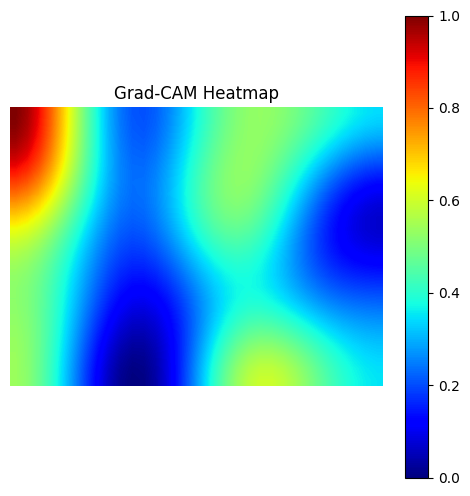

Activations shape: torch.Size([197, 32, 768])
Gradients shape: torch.Size([197, 32, 768])
Grad-CAM shape: torch.Size([197, 768])


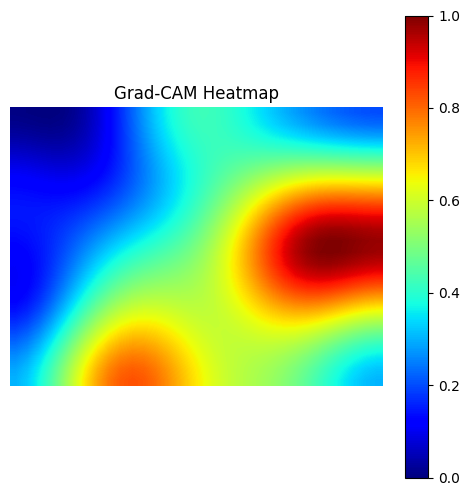

Activations shape: torch.Size([197, 32, 768])
Gradients shape: torch.Size([197, 32, 768])
Grad-CAM shape: torch.Size([197, 768])


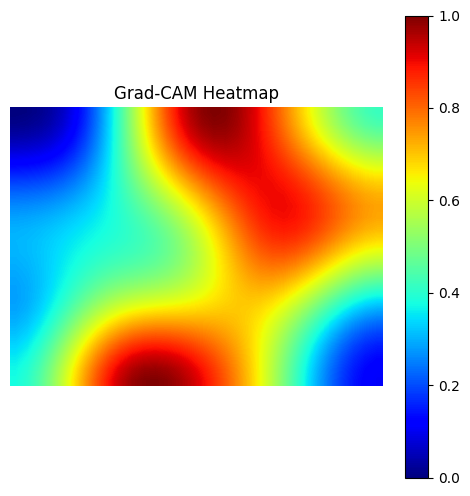

Activations shape: torch.Size([197, 32, 768])
Gradients shape: torch.Size([197, 32, 768])
Grad-CAM shape: torch.Size([197, 768])


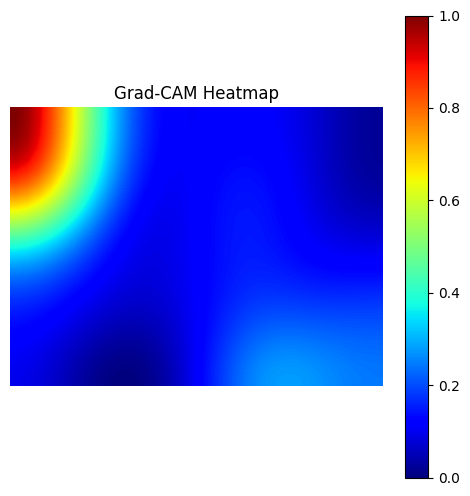

In [ ]:
# Example model (replace with actual UniformerV2 model)
# model = ...  # Load your UniformerV2 model here

target_layers = ["transformer.resblocks.11.ln_2","transformer.resblocks.11.ln_1","transformer.resblocks.10.ln_2","transformer.resblocks.10.ln_1","transformer.resblocks.9.ln_2","transformer.resblocks.9.ln_1","transformer.resblocks.8.ln_2","transformer.resblocks.8.ln_1","transformer.dec.0.ln_1", "transformer.dec.0.ln_2","transformer.dec.0.ln_3","transformer.dec.1.ln_1","transformer.dec.1.ln_2","transformer.dec.1.ln_3","transformer.dec.2.ln_1","transformer.dec.2.ln_2","transformer.dec.2.ln_3","transformer.dec.3.ln_1","transformer.dec.3.ln_2","transformer.dec.3.ln_3"]
for target_layer in target_layers:
# target_layer = 'transformer.dec.0.ln_2'  # For example, last attention layer

    # Specify input size (H, W)
    input_size = (224, 224)  # Or (height, width) for your video frames
    grad_cam = GradCAM(model=model, target_layer_name=target_layer)
    # Example input (C, F, H, W)
    # target_class = 3  # Class index to visualize

    # Generate heatmap
    heatmap = grad_cam(input_tensor, target_class)
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.cm as cm
    from scipy.ndimage import gaussian_filter

    def plot_grad_cam(grad_cam, original_image=None, target_height=None, target_width=None, smooth=True):
        # Normalize the Grad-CAM output to [0, 1] for visualization
        grad_cam = (grad_cam - np.min(grad_cam)) / (np.max(grad_cam) - np.min(grad_cam))  # Normalize to [0, 1]

        # Determine the correct height and width for reshaping based on num_tokens
        num_tokens = grad_cam.shape[0]
        
        # For 768 tokens, we can assume a 24x32 grid (or adjust as needed for other models)
        if num_tokens == 768:
            height, width = 24, 32
        else:
            # If your model uses a different number of tokens, adjust here accordingly
            sqrt_tokens = int(np.sqrt(num_tokens))
            height, width = sqrt_tokens, num_tokens // sqrt_tokens
            if height * width != num_tokens:
                raise ValueError(f"Cannot reshape {num_tokens} tokens into a square grid")

        grad_cam = grad_cam.reshape(height, width)

        # Default grad_cam_resized to the original grad_cam
        grad_cam_resized = grad_cam

        # Upsample the Grad-CAM heatmap to the target size (if original image is provided)
        if original_image is not None:
            # Get target size from the original image (height, width)
            target_height = target_height or original_image.shape[1]  # Use original image height if not provided
            target_width = target_width or original_image.shape[2]  # Use original image width if not provided
            
            # Use bilinear interpolation to resize the Grad-CAM heatmap
            grad_cam_resized = resize(grad_cam, (target_height, target_width), mode='reflect', anti_aliasing=True)

        # Apply Gaussian smoothing if requested
        if smooth:
            grad_cam_resized = gaussian_filter(grad_cam_resized, sigma=5)  # You can adjust sigma for more/less smoothing

        # Normalize again after smoothing to ensure proper scaling
        grad_cam_resized = (grad_cam_resized - np.min(grad_cam_resized)) / (np.max(grad_cam_resized) - np.min(grad_cam_resized))

        # Plot Grad-CAM Heatmap only
        fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis
        ax.imshow(grad_cam_resized, cmap='jet', interpolation='bilinear')  # Use bilinear interpolation
        ax.axis('off')  # Hide axes
        plt.colorbar(ax.imshow(grad_cam_resized, cmap='jet', interpolation='bilinear'))  # Add color bar
        plt.title("Grad-CAM Heatmap")
        plt.show()

        # Option 2: Overlay Grad-CAM on the original image (if provided)
        if original_image is not None:
            # Assuming original_image is in shape [C, H, W], we need to transpose it to [H, W, C]
            original_image = np.transpose(original_image, (1, 2, 0))  # [C, H, W] -> [H, W, C]
            
            # Convert Grad-CAM to RGB format using a colormap
            grad_cam_rgb = cm.jet(grad_cam_resized)[..., :3]  # Remove alpha channel (RGBA -> RGB)
            
            # Overlay Grad-CAM on the original image
            overlay = 0.6 * grad_cam_rgb + 0.4 * original_image  # Blend Grad-CAM with original image
            overlay = np.clip(overlay, 0, 1)  # Ensure values are between 0 and 1

            # Plot the overlay
            fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis
            ax.imshow(overlay)
            ax.axis('off')  # Hide axes
            plt.title("Grad-CAM Overlay")
            plt.show()

    plot_grad_cam(heatmap, None)
